In [17]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from model import FNO1d
from utils import relative_l2_error, PDEDataset

In [18]:
torch.manual_seed(0)
np.random.seed(0)

In [19]:
N_TRAIN = 64 # number of training samples
BATCH_SIZE = 10

In [20]:
training_data = PDEDataset("../../data/FNO - Wave Equation/train_sol.npy")
# choose N_TRAIN samples randomly
val_data, train_data = torch.utils.data.random_split(training_data, [N_TRAIN, len(training_data) - N_TRAIN])

In [21]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

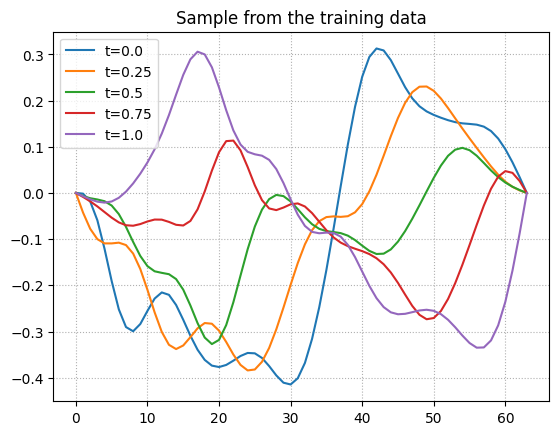

In [22]:
# plot a random sample from the training data
sample = train_data[np.random.randint(0, len(train_data))]

for t in range(len(sample)):
    plt.plot(sample[t, :, 0].numpy(), label=f't={t / 4}')

plt.grid(True, which="both", ls=":")
plt.title("Sample from the training data")
plt.legend()

In [23]:
learning_rate = 0.001
epochs = 500
step_size = 100
gamma = 0.5

In [24]:
modes = 16
width = 64
fno = FNO1d(modes, width)  # model

In [25]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# loss_f = torch.nn.MSELoss()
loss_f = relative_l2_error

In [26]:
fno.train()

progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    train_loss = 0.0
    count = 0
    for input_batch in train_data_loader:
        input = input_batch[:, 0, :]
        target = input_batch[:, -1, :, 0]

        optimizer.zero_grad()
        prediction = fno(input).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        count += len(input_batch)

    scheduler.step()

    progress_bar.set_postfix(
        {
            "train_loss": train_loss / count,
            "raw_loss": train_loss,
        }
    )


100%|██████████| 500/500 [00:30<00:00, 16.51it/s, train_loss=0.000531, raw_loss=0.034] 


In [27]:
# validate model

fno.eval()
progress_bar = tqdm.tqdm(val_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    count = 0
    for input_batch in progress_bar:
        input = input_batch[:, 0, :]
        target = input_batch[:, -1, :, 0]

        optimizer.zero_grad()
        prediction = fno(input).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
        count += len(input_batch)

    test_relative_l2 /= count


print("#" * 20)
print(f"[Validation] relative L2 error: {test_relative_l2}")

100%|██████████| 7/7 [00:00<00:00, 120.01it/s]

####################
[Validation] relative L2 error: 0.00830431270878762


In [28]:
# save model to disk
torch.save(fno.state_dict(), "models/fno_model.pth")